In [1]:
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, RandomSampler
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import matplotlib.pyplot as plt
from PIL import Image

/home/gaya/miniconda3/envs/DiffMenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set device to CPU (since we want to run without CUDA)
device = torch.device('cpu')

In [89]:
# Define the number of timesteps
num_timesteps = 10

In [ ]:
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)),  
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  
])


In [ ]:
mnist_dataset = MNIST(root='./', train=True, download=True, transform=transform)

sampler = RandomSampler(mnist_dataset, num_samples=100)  

data_loader = DataLoader(mnist_dataset, batch_size=2, sampler=sampler, num_workers=4)

In [92]:
# Initialize the Unet model
model = Unet(
    dim=64,
    dim_mults=(1, 2, 4, 8)
).to(device)

In [ ]:
# Initialize the GaussianDiffusion object
diffusion = GaussianDiffusion(
    model,
    image_size=128,
    timesteps=num_timesteps,   
).to(device)

In [94]:
# Initialize your optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [95]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    for images, _ in data_loader:
        images = images.to(device)
        
        optimizer.zero_grad()
        loss = diffusion(images)
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/1], Loss: 1.0495
Epoch [1/1], Loss: 1.4908
Epoch [1/1], Loss: 1.0500
Epoch [1/1], Loss: 0.4223
Epoch [1/1], Loss: 0.8385
Epoch [1/1], Loss: 0.3749
Epoch [1/1], Loss: 0.3453
Epoch [1/1], Loss: 1.6487
Epoch [1/1], Loss: 0.3904
Epoch [1/1], Loss: 0.4062
Epoch [1/1], Loss: 0.3084
Epoch [1/1], Loss: 1.0274
Epoch [1/1], Loss: 0.6009
Epoch [1/1], Loss: 0.2796
Epoch [1/1], Loss: 0.2493
Epoch [1/1], Loss: 0.9692
Epoch [1/1], Loss: 0.2635
Epoch [1/1], Loss: 0.3392
Epoch [1/1], Loss: 0.1297
Epoch [1/1], Loss: 0.5347
Epoch [1/1], Loss: 1.1133
Epoch [1/1], Loss: 0.3367
Epoch [1/1], Loss: 0.4887
Epoch [1/1], Loss: 0.3613
Epoch [1/1], Loss: 0.4504
Epoch [1/1], Loss: 0.6790
Epoch [1/1], Loss: 0.1018
Epoch [1/1], Loss: 0.2223
Epoch [1/1], Loss: 0.2855
Epoch [1/1], Loss: 0.2161
Epoch [1/1], Loss: 0.1478
Epoch [1/1], Loss: 1.1013
Epoch [1/1], Loss: 0.1359
Epoch [1/1], Loss: 0.1014
Epoch [1/1], Loss: 1.0883
Epoch [1/1], Loss: 0.1035
Epoch [1/1], Loss: 0.6172
Epoch [1/1], Loss: 0.2464
Epoch [1/1],

In [ ]:
# Generate images after training
with torch.no_grad():
    sample_images = diffusion.sample(2)  

sampling loop time step: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


In [ ]:
# Visualize the generated images
sample_images = (sample_images + 1) / 2  # Rescale to [0, 1]

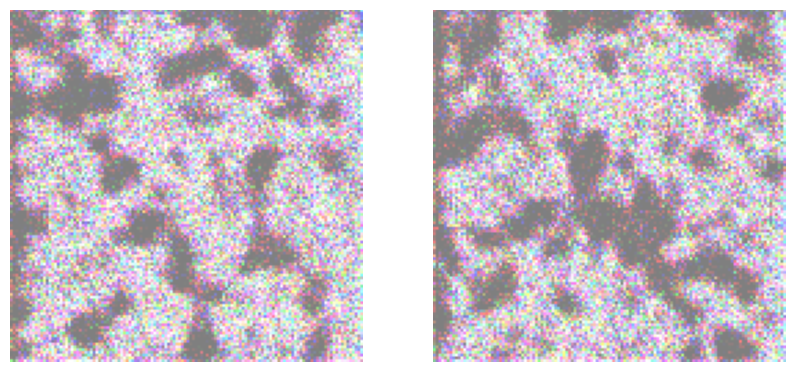

In [ ]:
# Plot the images
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(sample_images[i].permute(1, 2, 0).numpy())  # Change from (C, H, W) to (H, W, C)
    plt.axis('off')
plt.show()

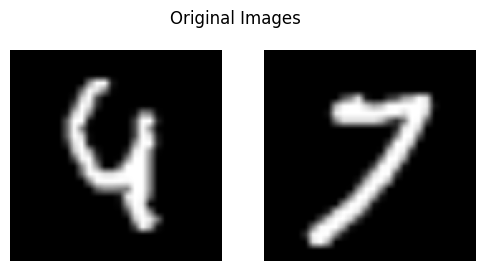

In [ ]:
original_images = next(iter(data_loader))[0].to(device)

# Display the original images
def show_images(images, title='Original Images'):
    """Utility function to display images."""
    num_images = images.shape[0]
    plt.figure(figsize=(num_images * 3, 3))  
    for i in range(num_images):
        img = (images[i][0].cpu().numpy() + 1) / 2 
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_images(original_images)  

In [ ]:
# Create a GIF for each image
for img_index in range(original_images.shape[0]):
    original_image = original_images[img_index:img_index+1]  # Shape: (1, C, H, W)
    
    # Prepare to collect images for GIF
    frames = []
    
    # Start with the original image as the noisy image
    noise_images = original_image.clone()  
    
    # Create frames with increasing noise
    for t in range(1, num_timesteps + 1):  
        noise_factor = torch.randn_like(noise_images) * (t / num_timesteps)  
        noisy_images = torch.clamp(noise_images + noise_factor, -1, 1)  
        img = (noisy_images[0][0].cpu().numpy() + 1) / 2  
        img = (img * 255).astype(np.uint8)
        frames.append(Image.fromarray(img, mode='L'))  

    # Reverse diffusion process
    for t in reversed(range(num_timesteps)):  
        with torch.no_grad():
            # Denoise step
            denoised_images, _ = diffusion.p_sample(noisy_images, t)  
            img = (denoised_images[0][0].cpu().numpy() + 1) / 2  
            img = (img * 255).astype(np.uint8)
            frames.append(Image.fromarray(img, mode='L'))  
            
            # Update noise_images for the next step
            noisy_images = denoised_images.clone() 

    # Create GIF from frames
    output_gif_path = f'denoising_progression_image_{img_index + 1}.gif'
    frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], duration=100, loop=0)

    print(f'GIF saved at {output_gif_path}')

GIF saved at denoising_progression_image_1.gif
GIF saved at denoising_progression_image_2.gif


In [ ]:
# Create GIFs for Gaussian Noise to Original MNIST Digits
for img_index in range(original_images.shape[0]):
    original_image = original_images[img_index:img_index + 1]  # Shape: (1, C, H, W)
    
    # Prepare to collect images for GIF
    frames = []
    
    # Start with Gaussian noise
    noise_images = torch.randn_like(original_image)  # Generate Gaussian noise

    # Create frames showing progression from noise to the original image
    for t in range(1, num_timesteps + 1):  # Adjust noise level
        # Interpolate between the noisy image and the original image
        interpolation_factor = t / num_timesteps
        interpolated_image = noise_images * (1 - interpolation_factor) + original_image * interpolation_factor
        img = (interpolated_image[0][0].cpu().numpy() + 1) / 2  # Rescale to [0, 1]
        img = (img * 255).astype(np.uint8)
        frames.append(Image.fromarray(img, mode='L'))  # Append interpolated image

    # Create GIF from frames
    output_gif_path = f'gaussian_noise_to_mnist_image_{img_index + 1}.gif'
    frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], duration=100, loop=0)

    print(f'GIF saved at {output_gif_path}')

GIF saved at gaussian_noise_to_mnist_image_1.gif
GIF saved at gaussian_noise_to_mnist_image_2.gif
